In [8]:
import matplotlib.pyplot as plt
import tensorflow as tf
from load_datasets import load_mnist_imgs_and_labels
import numpy as np

In [9]:
# config
batch_size = 128
test_batch_size = 512
epochs = 5
lr = 1e-2
momentum = 0.9
log_interval = 200 # ?
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# from_logits=False in case of softmax activation, =True in any other case
# logits being whot comes out of output neurons after feed forward before applying last activation

# no need to check whether CUDA is used as it is prioritized by default in TensorFlow
# device used printed out at model compilation

In [10]:
x_train, y_train = load_mnist_imgs_and_labels(
	'../datasets/mnist-digits/train-images.idx3-ubyte',
	'../datasets/mnist-digits/train-labels.idx1-ubyte'
)

x_test, y_test = load_mnist_imgs_and_labels(
	'../datasets/mnist-digits/t10k-images.idx3-ubyte',
	'../datasets/mnist-digits/t10k-labels.idx1-ubyte'
)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(test_batch_size)

2023-05-08 22:27:05.611141: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376320000 exceeds 10% of free system memory.
2023-05-08 22:27:05.931448: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376320000 exceeds 10% of free system memory.


In [11]:
class FullyConnectedNet(tf.keras.Model):

	def __init__(self, hidden_layers=[800], num_classes=10):
		super().__init__()
		self.hidden_layers = tf.keras.Sequential([
			tf.keras.layers.Dense(n, activation=tf.nn.relu) for n in hidden_layers
		])
		self.output_layer = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
		# TensorFlow best practice is to use softmax activation on last layer
		# combined with *Crossentrpy(from_logits=False) loss function
		# instead of LogSoftmax (like in PyTorch) since NLL loss func is not implemented in TF


	def call(self, x):
		x = self.hidden_layers(x)
		return self.output_layer(x)

# sequential builder, will most probably become obsolete
# since eventually I want to use subclassing api like in PyTorch 
def FullyConnectedNetBuilder(hidden_layers=[800], num_classes=10):
  layers = [tf.keras.layers.Dense(n, activation=tf.nn.relu) for n in hidden_layers]
  layers.append(tf.keras.layers.Dense(num_classes, activation='log_softmax'))
  return tf.keras.Sequential(layers)

In [12]:
model = FullyConnectedNet()

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

In [13]:
train_history = model.fit(
	train_ds,
	validation_data=test_ds,
	validation_batch_size=test_batch_size,
	epochs=epochs
)

Epoch 1/5


2023-05-08 22:27:06.671213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60000,784]
	 [[{{node Placeholder/_0}}]]
2023-05-08 22:27:06.671479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]


469/469 [==============================] - 2s 3ms/step - loss: 0.5144 - accuracy: 0.8438 - val_loss: 0.3382 - val_accuracy: 0.8971
Epoch 2/5
  1/469 [..............................] - ETA: 2s - loss: 0.3423 - accuracy: 0.8984

2023-05-08 22:27:08.386308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [10000]
	 [[{{node Placeholder/_1}}]]


469/469 [==============================] - 1s 3ms/step - loss: 0.3157 - accuracy: 0.9075 - val_loss: 0.3334 - val_accuracy: 0.9008
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.2600 - accuracy: 0.9244 - val_loss: 0.2215 - val_accuracy: 0.9340
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.2191 - accuracy: 0.9365 - val_loss: 0.2445 - val_accuracy: 0.9251
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1896 - accuracy: 0.9455 - val_loss: 0.1768 - val_accuracy: 0.9469


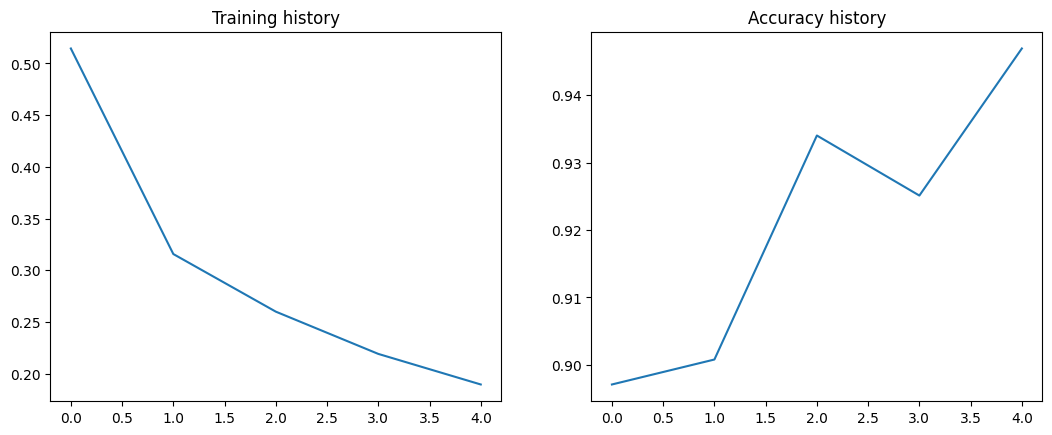

In [14]:
fig, (ax_train, ax_test) = plt.subplots(1, 2)
fig.set_size_inches(12.8, 4.8)

ax_train.plot(train_history.history['loss'])
ax_test.plot(train_history.history['val_accuracy'])
ax_train.set_title('Training history')
ax_test.set_title('Accuracy history')

plt.show(fig)